<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_JB_data_PF_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-image --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
!pip install cellpose --quiet

In [37]:
import matplotlib
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from tqdm import tqdm
import scipy as sci
from cellpose import models
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [36]:
""" PLOT CONFIG """
### quick import
import urllib
import json
import matplotlib as mpl
from matplotlib import rcParams
def import_mpl_config(FS=6):
    """ Load my default plotting parameters """
    if os.path.isfile(f'./mpl_config_FS{FS}.json'):
        os.remove(f'./mpl_config_FS{FS}.json')
    _ = urllib.request.urlretrieve('https://github.com/dtabuena/Resources/'\
                                   'raw//main/Matplotlib_Config/'\
                                   f'mpl_config_FS{FS}.json',
                                   f'mpl_config_FS{FS}.json')
    with open(f"./mpl_config_FS{FS}.json",'r') as import_file:
        fig_config = json.load(import_file)
    rcParams.update(fig_config)
    _ = urllib.request.urlretrieve('https://github.com/dtabuena/Resources/raw/main/Fonts/arial.ttf','arial.ttf')
    mpl.font_manager.fontManager.addfont('./arial.ttf')
    return fig_config
_ = import_mpl_config()

In [41]:
"""NeuN vol divided by Num Nuclei"""

# for curr_tif in tqdm(tiff_list):

def calc_neun_layer_mask(tiff_data_raw,thresh=0.2):
    max_neun = np.max(tiff_data_raw[:,1,:,:],axis=0)
    neun_z = (max_neun - np.mean(max_neun)) / np.std(max_neun)
    chunks = ski.measure.label(neun_z>thresh)*1.0
    size,label=np.histogram(chunks,bins=np.unique(chunks))
    label=label[1:-1]
    size=size[1:]
    chunk_sizes ={l:s for l,s in zip(label,size)}
    biggest = label[size == np.nanmax(size)]
    neun_layer_mask = chunks==biggest
    neun_layer_mask_4d=np.stack([neun_layer_mask]*tiff_data_raw.shape[1],axis=0)
    neun_layer_mask_4d=np.stack([neun_layer_mask_4d]*tiff_data_raw.shape[0],axis=0)
    tiff_data_masked = tiff_data_raw*neun_layer_mask_4d
    return neun_layer_mask, tiff_data_masked

def mean_volumes(nuclear_masks,tiff_data_masked,neun_layer_mask):
    # plt.imshow(np.sum(nuclear_masks,axis=0))

    neun = tiff_data_masked[:,1,:,:]
    neun_z = (neun - np.mean(neun)) / np.std(neun)
    neun_pos = neun_z >0.5

    num_nuclei = np.max(nuclear_masks)

    neun_vox_vol = np.sum(neun_pos)
    voxel_dim_um=np.array([0.3977476,0.3977476,0.5])
    voxel_vol_um3 = np.prod(voxel_dim_um)
    neun_vox_vol_um3 = neun_vox_vol * voxel_vol_um3
    mean_vol_um3 = neun_vox_vol_um3/num_nuclei
    return (mean_vol_um3, num_nuclei,neun_vox_vol_um3)


def np_to_rgb(raw,channel_bal=[1,1,1]):
    norm = (raw - np.min(raw))/(np.max(raw) - np.min(raw))
    rgb = np.stack( [norm*channel_bal[0],
                     norm*channel_bal[1],
                     norm*channel_bal[2],
                     ],axis=-1)
    return rgb

In [3]:
def plot_point_data_pcol(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None,cmap='viridis'):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x]
        x=rad
        y=rad

    xy_slice = image_stack[z,:,:]
    zy_slice = image_stack[:,:,x].transpose([1,0])
    zx_slice = image_stack[:,y,:]

    vmin = np.percentile(image_stack,.1)
    vmax = np.percentile(image_stack,99.9)
    print(vmin,vmax)

    fig,ax=plt.subplots(2,3,width_ratios=[5, 1, .5],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax=ax.flatten()
    # ,aspect='auto'
    cbh=ax[0].pcolorfast(xy_slice,zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])
    ax[0].invert_yaxis()

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[3].imshow(zx_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[3].axvline(x,color='m',linewidth=lw)
    ax[3].axhline(z,color='y',linewidth=lw)

    plt.colorbar(cbh,cax=ax[2])

    for a in ax[4:]:
        a.axis('off')
    plt.tight_layout()
    return fig,ax,cbh

In [ ]:
def plot_point_data_rgb(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    print(image_stack.shape,x,y)

    xy_slice = image_stack[z,:,:,:]
    zy_slice = image_stack[:,:,x,:].transpose([1,0,2])
    zx_slice = image_stack[:,y,:,:]


    z_ratio = image_stack.shape[0]/image_stack.shape[1]

    fig,ax=plt.subplots(2,2,width_ratios=[1, z_ratio],height_ratios=(1,z_ratio),figsize=figsize,dpi=300)
    ax=ax.flatten()

    ax[0].imshow(xy_slice,aspect='auto',zorder=-1) # vmin=vmin,vmax=vmax,cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[2].imshow(zx_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[2].axvline(x,color='m',linewidth=lw)
    ax[2].axhline(z,color='y',linewidth=lw)




    ax[3].axis('off')
    plt.tight_layout()
    return fig,ax



def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    tiff_format = 'zcyx'
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = ski.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img


In [4]:
""" Propper Funcs """

def trim_edge_bound(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]

    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og

def fit_cell_model(img_rgb, cell_channel=1, nuclear_channel=0,channel_axis=3):
    cell_diam=40
    cell_model = models.Cellpose(model_type='cyto3',gpu=True)
    (cell_masks, flows, styles, diams) = cell_model.eval(
        img_rgb, channels=[cell_channel,nuclear_channel],
        channel_axis = channel_axis, diameter=cell_diam,
        do_3D=False, stitch_threshold=0.02)

    results_dict = {'cell_masks':cell_masks,
                'flows':flows,
                'styles':styles,
                'diams':diams,
                'cell_model':cell_model,}
    return results_dict

def fit_nuclear_model(img_rgb,nuclear_channel=3,channel_axis=3):
    nuc_diam = None
    nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
    (nuclear_masks, _, _, _)=  nuclear_model.eval(
        img_rgb, channels=[nuclear_channel, 0],
        channel_axis = channel_axis, diameter=nuc_diam,
        do_3D=False, stitch_threshold=0.02,)
    return nuclear_masks

def tiff_to_RGB_stack(tiff_data,rbg_channel_order = [1,0,0]):
    tiff_data = tiff_data[:,rbg_channel_order,:,:]
    tiff_data[:,1,:,:]=0
    rgb_stack = tiff_data.transpose([0,2,3,1])*225
    rgb_stack[rgb_stack<0]=0
    rgb_stack[rgb_stack>255]=255
    rgb_stack=rgb_stack.astype('uint8')
    return rgb_stack

def preprocess_image(tiff_data):
    tiff_data = ski.filters.gaussian(
        tiff_data, sigma=[1,1,1],
        mode='reflect',truncate = 4,
        channel_axis=1)
    tiff_data = med_filt_stack(tiff_data,5)
    tiff_data = norm_channels(tiff_data,'zcxy',clip=True,pct=[99,1])
    return tiff_data

def split_proj(tiff_data):
    print(tiff_data.shape)
    num_c = tiff_data.shape[3]
    fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
    colors = ['Reds','Greens','Blues','gray']
    for c in range(num_c):
        ax[c].imshow(np.max(tiff_data[:,:,:,c],axis=0), cmap=colors[c],vmin=0,vmax=255)
        ax[c].axis('off')
    plt.tight_layout()


def norm_channels(im_data,tiff_format,clip=False,pct=[99,1]):
    print(im_data.shape)
    color_dim = tiff_format.index('c')
    print('norm color dim =',color_dim)
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),pct)
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data




In [5]:
def save_masks(cell_masks,nuclear_masks,cell_masks_og,curr_tif):
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    np.save( image_name+'_cell_masks',cell_masks,allow_pickle=True)
    np.save( image_name+'_nuclear_masks',nuclear_masks,allow_pickle=True)
    np.save( image_name+'_cell_masks_og',cell_masks_og,allow_pickle=True)



In [16]:
"""MAIN"""

def qunatify_image_stack(curr_tif):
    tiff_data_raw = tifffile.imread(curr_tif)
    tiff_data = preprocess_image(tiff_data_raw)
    rgb_stack = tiff_to_RGB_stack(tiff_data)
    split_proj(rgb_stack)

    nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3,channel_axis=3)
    results_dict = fit_cell_model(rgb_stack,channel_axis=3)
    cell_masks = results_dict['cell_masks']
    cell_masks, cell_masks_og = trim_edge_bound(cell_masks)
    save_masks(cell_masks,nuclear_masks,cell_masks_og,curr_tif)



In [15]:
def load_masks(curr_tif):
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    cell_masks = np.load( image_name+'_cell_masks.npy')
    nuclear_masks = np.load( image_name+'_nuclear_masks.npy')
    cell_masks_og = np.load( image_name+'_cell_masks_og.npy')
    return (cell_masks,nuclear_masks,cell_masks_og)

In [ ]:
curr_tif
found_cells = np.sum(cell_masks>0,axis=0)
tifffile.imwrite('found_cells.tif',found_cells)
# plt.imshow(found_cells)

tiff_data_raw = tifffile.imread(curr_tif)
neun_slice = tiff_data_raw[14,1,:,:]
tifffile.imwrite('neun_slice.tif',neun_slice)

In [ ]:
def find_child_nucleii(cell_masks,nuclear_masks,cell_df):
    cell_df['nucleii']=np.nan
    cell_df['nuc_count']=np.nan
    cell_df['nucleii']=cell_df['nucleii'].astype(object)
    for cell in cell_df.index:
        cell_nuc_overlap = nuclear_masks [cell_masks==cell]
        cell_nuc_overlap=[n for n in cell_nuc_overlap if n>0]
        cell_df.at[cell,'nucleii'] = np.unique(cell_nuc_overlap)
        cell_df.at[cell,'nuc_count'] = cell_df.at[cell,'nucleii'].size
    return cell_df


def analyze_ferrets(cell_df,cell_masks,voxel_dim_um):

    cell_df['feret_d']=np.nan
    cell_df['feret_d']= cell_df['feret_d'].astype(object)
    for id in cell_df.index:
        cell_df.at[id,'feret_d'] = nd_feret(cell_masks==id,zxy_scalars=voxel_dim_um[[2,0,1]])

    ferrets = cell_df['feret_d'].to_numpy()
    ferrets = np.stack(ferrets,axis=0)
    cell_df['feret_z'] = ferrets[:,0]
    cell_df['feret_x'] = ferrets[:,1]
    cell_df['feret_y'] = ferrets[:,2]
    cell_df['min_fer'] = np.min(ferrets,axis=1)
    cell_df['box_vol'] = np.prod(ferrets,axis=1)
    cell_df['pct_fill'] = cell_df['sizes_um3']/cell_df['box_vol']

    return cell_df

def nd_feret(mask,zxy_scalars=None):
    if zxy_scalars is None:
        scalars=np.ones_like(mask.shape)
    n_coords=np.where(mask)
    feret_diams = list()
    for s, coord in zip(zxy_scalars,n_coords):
        diam = np.max(coord)-np.min(coord)+1
        feret_diams.append(diam*s)
    return np.asarray(feret_diams)

In [ ]:
def analyze_cell_mask(cell_masks,nuclear_masks):

    voxel_dim_um=np.array([0.3977476,0.3977476,0.5])
    voxel_vol_um3 = np.prod(voxel_dim_um)

    cell_masks_f = cell_masks.flatten()
    cell_ids = np.unique(cell_masks_f)
    bins = np.insert(cell_ids+0.5, 0, -0.5, axis=0)
    (sizes_px, edges) = np.histogram(cell_masks_f,bins=bins)
    sizes_um3 = sizes_px*voxel_vol_um3

    # print('\n',len(cell_ids),len(sizes_px),len(sizes_um3))
    cell_df = pd.DataFrame({'cell_ids':cell_ids[1:],'sizes_px':sizes_px[1:],
                            'sizes_um3':sizes_um3[1:]}).set_index('cell_ids')

    cell_df =  analyze_ferrets(cell_df,cell_masks,voxel_dim_um)
    cell_df = find_child_nucleii(cell_masks,nuclear_masks,cell_df)

    """ FILTERING """
    cell_df = cell_df[cell_df['nuc_count']<2]
    cell_df = cell_df[cell_df['pct_fill']>.4]
    cell_df = cell_df[cell_df['min_fer']>1]

    return cell_df['sizes_um3'].values, cell_df




100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:22<00:00,  6.85s/it]


In [ ]:
my_tiffs_ones = [t for t in my_tiffs if '_1.tif' in t]
my_tiffs_twos = [t for t in my_tiffs if '_2.tif' in t]

tiff_list = my_tiffs

volumes_lists = list()
for curr_tif in tqdm(tiff_list):
    (cell_masks,nuclear_masks,cell_masks_og) = load_masks(curr_tif)
    volumes, df = analyze_cell_mask(cell_masks,nuclear_masks)
    volumes_lists.append(volumes)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:41<00:00,  6.72s/it]


In [ ]:
vol_resolution = 50

combined_vols = np.concatenate(volumes_lists)
counts, edges = np.histogram(combined_vols,bins=np.arange(0,1800,vol_resolution))
bin_centers = edges[1:] - np.diff(edges)/2
prob = counts/np.sum(counts)
plt.stairs(np.cumsum(prob),edges,color='k')
vol_dist_df=pd.DataFrame({'tiff':tiff_list,'volume_lists':volumes_lists}).set_index('tiff')
# display(vol_dist_df.head())



"""
combine slices 1 and 2
"""
vol_dist_df_consolidated = vol_dist_df.copy()
for tiff in my_tiffs_ones:
    tiff_match = tiff.replace('_1.tif','_2.tif')
    one_vols = vol_dist_df_consolidated.loc[tiff,'volume_lists']
    two_vols = vol_dist_df_consolidated.loc[tiff_match,'volume_lists']
    vol_dist_df_consolidated.at[tiff,'volume_lists'] = np.concatenate([one_vols,two_vols])
    vol_dist_df_consolidated = vol_dist_df_consolidated.drop(tiff_match,axis=0)
display(vol_dist_df_consolidated)

vol_dist_df = vol_dist_df_consolidated
tiff_list = list(vol_dist_df.index)

In [ ]:

vol_dist_df['counts']=np.nan
vol_dist_df['counts']=vol_dist_df['counts'].astype('object')
vol_dist_df['edges']=np.nan
vol_dist_df['edges']=vol_dist_df['edges'].astype('object')
vol_dist_df['probabilities']=np.nan
vol_dist_df['probabilities']=vol_dist_df['probabilities'].astype('object')



for tiff in vol_dist_df.index:
    vols = vol_dist_df.loc[tiff,'volume_lists']
    counts, edges = np.histogram(vols,bins=np.arange(0,1800,vol_resolution))
    cd_probs = np.cumsum(counts/np.sum(counts))
    # plt.stairs(np.cumsum(prob),edges)
    vol_dist_df.at[tiff,'edges']=edges
    vol_dist_df.at[tiff,'counts']=counts
    vol_dist_df.at[tiff,'probabilities']=cd_probs

vol_dist_df['geno'] = ['E4' if 'E4' in t else 'E3' for t in vol_dist_df.index]
display(vol_dist_df.head(3))

df_ages = [age_dict[os.path.basename(t)] for t in vol_dist_df.index]
vol_dist_df['age'] = df_ages

,volume_lists,counts,edges,probabilities,geno,age
tiff,,,,,,
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\DAPI-NeuN_E3-E_20x2_1.tif,"[334.0459582051122, 495.650479306946, 145.0722...","[0, 1, 4, 2, 2, 3, 2, 3, 3, 3, 2, 0, 0, 2, 0, ...","[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[0.0, 0.034482758620689655, 0.1724137931034483...",E3,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\DAPI-NeuN_E3-F_20x2_1.tif,"[97.37404085969527, 398.9883526371267, 471.208...","[0, 3, 4, 2, 2, 4, 4, 4, 2, 3, 5, 2, 1, 0, 1, ...","[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[0.0, 0.075, 0.175, 0.22499999999999998, 0.274...",E3,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\DAPI-NeuN_E3-G_20x2_1.tif,"[245.76859866049813, 678.3751213750988, 219.50...","[0, 2, 2, 0, 2, 2, 4, 2, 1, 1, 1, 1, 0, 1, 1, ...","[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[0.0, 0.08695652173913043, 0.17391304347826086...",E3,10


In [ ]:
# obs_abs_delta, obs_raw_delta = eval_sample(true_key,joint_cdf_mat)
# obs_raw_delta.shape
X = obs_raw_delta>0

import skimage

def analyze_full_delta(raw_delta):
    positives = skimage.measure.label(raw_delta>0)
    positives_chunks = np.unique(positives)
    positives_chunks = [p for p in positives_chunks if p>0]
    if len(positives_chunks)>0:
        pos_patch_area = [np.sum(positives==p) for p in positives_chunks]
        pos_patch_density = [np.sum(raw_delta[positives==p]) for p in positives_chunks]
        max_pos_area = np.max(pos_patch_area)
        max_pos_density = np.max(pos_patch_density)
    else:
        max_pos_area=0
        max_pos_density=0


    negatives = skimage.measure.label(raw_delta<0)
    negatives_chunks = np.unique(negatives)
    negatives_chunks = [p for p in negatives_chunks if p>0]
    if len(negatives_chunks)>0:
        neg_patch_area = [np.sum(negatives==p) for p in negatives_chunks]
        neg_patch_density = [np.sum(raw_delta[negatives==p]) for p in negatives_chunks]
        max_negative_area = np.max(neg_patch_area)
        min_negative_intensity = np.min(neg_patch_density)

    else:
        max_negative_area=0
        min_negative_intensity=0

    return np.asarray([max_pos_area, max_pos_density, max_negative_area, min_negative_intensity])


analyze_full_delta(obs_raw_delta)

array([11.        ,  0.07498969,  9.        , -0.42633357])

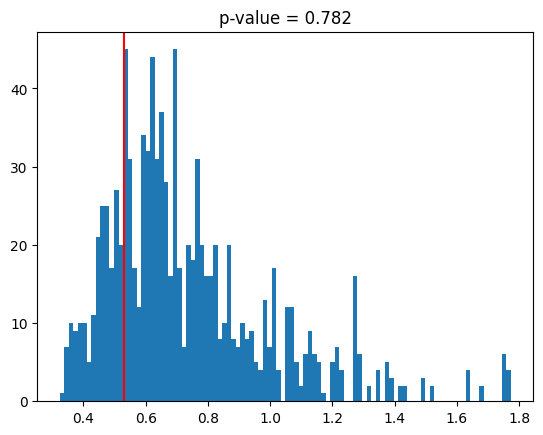

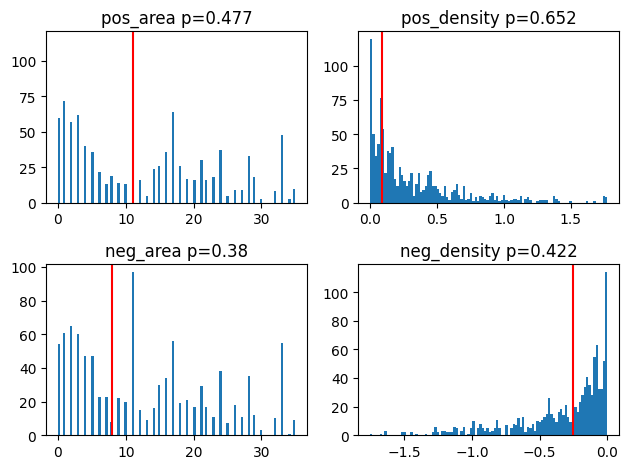

In [ ]:
# cdf_mat =


def permute_cdf_test(true_key,joint_cdf_mat,n_per=1000):
    obs_abs_delta, obs_raw_delta = eval_sample(true_key,joint_cdf_mat)
    obs_delta_stats = analyze_full_delta(obs_raw_delta)
    perm_delta_list = list()
    perm_delta_raw_list = list()
    for a in np.arange(n_per):
        perm_key = true_key.copy()
        np.random.shuffle(perm_key)
        perm_abs_delta, perm_full_delta = eval_sample(perm_key,joint_cdf_mat)
        perm_delta_list.append(perm_abs_delta)
        perm_delta_raw_stats = analyze_full_delta(perm_full_delta)
        perm_delta_raw_list.append(perm_delta_raw_stats)
    perm_delta_raw_arr = np.stack(perm_delta_raw_list)

    fig,ax=plt.subplots(1)
    ax.hist(perm_delta_list,bins=100)
    ax.axvline(obs_abs_delta,color='r')
    pval = np.mean(obs_abs_delta>=perm_delta_list)
    ax.set_title(f'p-value = {1-pval}')

    fig,ax=plt.subplots(2,2)
    ax=ax.flatten()
    ax[0].hist(perm_delta_raw_arr[:,0],bins=100)
    ax[0].axvline(obs_delta_stats[0],color='r')
    ax[0].set_title(f'pos_area p={np.mean(obs_delta_stats[0]<perm_delta_raw_arr[:,0]) }')

    ax[1].hist(perm_delta_raw_arr[:,1],bins=100)
    ax[1].axvline(obs_delta_stats[1],color='r')
    ax[1].set_title(f'pos_density p={np.mean(obs_delta_stats[1]<perm_delta_raw_arr[:,1]) }')

    ax[2].hist(perm_delta_raw_arr[:,2],bins=100)
    ax[2].axvline(obs_delta_stats[2],color='r')
    ax[2].set_title(f'neg_area p={np.mean(obs_delta_stats[2]>perm_delta_raw_arr[:,2]) }')

    ax[3].hist(perm_delta_raw_arr[:,3],bins=100)
    ax[3].axvline(obs_delta_stats[3],color='r')
    ax[3].set_title(f'neg_density p={np.mean(obs_delta_stats[3]>perm_delta_raw_arr[:,3]) }')

    plt.tight_layout()


def eval_sample(test_key,joint_cdf_mat):
    samp1 = joint_cdf_mat[test_key,:]
    samp2 = joint_cdf_mat[~test_key,:]

    raw_delta = np.mean(samp1,axis=0)-np.mean(samp2,axis=0)
    abs_delta= np.sum(np.abs(raw_delta))
    return abs_delta, raw_delta

true_key = vol_dist_df['geno'].values=='E3'
joint_cdf_mat = np.stack(vol_dist_df['probabilities'].values)
permute_cdf_test(true_key,joint_cdf_mat)


In [ ]:
vol_dist_df_10MO = vol_dist_df[vol_dist_df['age']==10]
true_key = vol_dist_df_10MO['geno'].values=='E3'
joint_cdf_mat = np.stack(vol_dist_df_10MO['probabilities'].values)
permute_cdf_test(true_key,joint_cdf_mat,n_per=1000)


vol_dist_df_5MO = vol_dist_df[vol_dist_df['age']==5]
true_key = vol_dist_df_5MO['geno'].values=='E3'
joint_cdf_mat = np.stack(vol_dist_df_5MO['probabilities'].values)
permute_cdf_test(true_key,joint_cdf_mat,n_per=1000)

# true_key = vol_dist_df['geno'].values=='E3'
# joint_cdf_mat = np.stack(vol_dist_df['probabilities'].values)
# permute_cdf_test(true_key,joint_cdf_mat)





In [ ]:
E4_df = vol_dist_df[vol_dist_df['geno']=='E4']
E4_prob_values = np.stack( E4_df['probabilities'].values)
np.savetxt('E4_prob_values.csv',E4_prob_values,delimiter=",")


E4_vol_values = np.concatenate( E4_df['volume_lists'].values)
np.savetxt('E4_vol_values.csv',E4_vol_values,delimiter=",")

In [ ]:
E4_df = vol_dist_df[vol_dist_df['geno']=='E4']
E4_10_df = E4_df[E4_df['age']>7]
E4_5_df = E4_df[E4_df['age']<7]


E3_df = vol_dist_df[vol_dist_df['geno']=='E3']
E3_10_df = E3_df[E3_df['age']>7]
E3_5_df = E3_df[E3_df['age']<7]

E4_10_prob_values = np.stack( E4_10_df['probabilities'].values)
np.savetxt('E4_10_prob_values.csv',E4_10_prob_values,delimiter=",")
E4_10_vol_values = np.concatenate( E4_10_df['volume_lists'].values)
np.savetxt('E4_10_vol_values.csv',E4_10_vol_values,delimiter=",")

E3_10_prob_values = np.stack( E3_10_df['probabilities'].values)
np.savetxt('E3_10_prob_values.csv',E3_10_prob_values,delimiter=",")
E3_10_vol_values = np.concatenate( E3_10_df['volume_lists'].values)
np.savetxt('E3_10_vol_values.csv',E3_10_vol_values,delimiter=",")

E4_5_prob_values = np.stack( E4_5_df['probabilities'].values)
np.savetxt('E4_5_prob_values.csv',E4_5_prob_values,delimiter=",")
E4_5_vol_values = np.concatenate( E4_5_df['volume_lists'].values)
np.savetxt('E4_5_vol_values.csv',E4_5_vol_values,delimiter=",")

E3_5_prob_values = np.stack( E3_5_df['probabilities'].values)
np.savetxt('E3_5_prob_values.csv',E3_5_prob_values,delimiter=",")
E3_5_vol_values = np.concatenate( E3_5_df['volume_lists'].values)
np.savetxt('E3_5_vol_values.csv',E3_5_vol_values,delimiter=",")

In [ ]:
# E4_df = vol_dist_df[vol_dist_df['geno']=='E4']
# E4_prob_values = np.stack( E4_df['probabilities'].values)
# np.savetxt('E4_prob_values.csv',E4_prob_values,delimiter=",")
# E4_vol_values = np.concatenate( E4_df['volume_lists'].values)
# np.savetxt('E4_vol_values.csv',E4_vol_values,delimiter=",")

# E3_df = vol_dist_df[vol_dist_df['geno']=='E3']
# E3_prob_values = np.stack( E3_df['probabilities'].values)
# np.savetxt('E3_prob_values.csv',E3_prob_values,delimiter=",")
# E3_vol_values = np.concatenate( E3_df['volume_lists'].values)
# np.savetxt('E3_vol_values.csv',E3_vol_values,delimiter=",")

In [ ]:
"""
A=4πr2
V=4/3πr3
"""

E3_DG


In [7]:
def quantify_image_stack(curr_tif):
    tiff_data_raw = tifffile.imread(curr_tif)
    cell_layer_mask,tiff_data_masked = calc_neun_layer_mask(tiff_data_raw,thresh=0.2)
    tiff_data = preprocess_image(tiff_data_masked)
    rgb_stack = tiff_to_RGB_stack(tiff_data)
    split_proj(rgb_stack)

    nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3,channel_axis=3)
    results_dict = fit_cell_model(rgb_stack,channel_axis=3)
    cell_masks = results_dict['cell_masks']
    cell_masks, cell_masks_og = trim_edge_bound(cell_masks)
    save_masks(cell_masks,nuclear_masks,cell_masks_og,curr_tif)



In [ ]:



mean_vols_df = pd.DataFrame({'tiffs':my_tiffs}).set_index('tiffs')
for a in ['num_nuclei','neun_vox_vol_um3','mean_vol_um3']:
    mean_vols_df[a]=np.nan
    mean_vols_df[a]=mean_vols_df[a].astype('object')




for curr_tif in tqdm(my_tiffs):
    (cell_masks,nuclear_masks,cell_masks_og) = load_masks(curr_tif)
    tiff_data_raw = tifffile.imread(curr_tif)
    neun_layer_mask, tiff_data_masked = calc_neun_layer_mask(tiff_data_raw,thresh=0.1)
    mean_vol_um3, num_nuclei, neun_vox_vol_um3 = mean_volumes(nuclear_masks,tiff_data_masked,neun_layer_mask)
    mean_vols_df.at[curr_tif,'mean_vol_um3'] = mean_vol_um3
    mean_vols_df.at[curr_tif,'num_nuclei'] = num_nuclei
    mean_vols_df.at[curr_tif,'neun_vox_vol_um3'] = neun_vox_vol_um3



    # volumes, df = analyze_cell_mask(cell_masks,nuclear_masks)




mean_vols_df['geno'] = ['E4' if 'E4' in t else 'E3' for t in mean_vols_df.index]
mean_vols_df['age'] = [  age_dict[os.path.basename(t)]  for t in mean_vols_df.index]

display(mean_vols_df.head(24))
mean_vols_df.to_csv('mean_vols_df.csv')

In [34]:
mean_vols_df['gene_enc'] =[('E4' in v) for v in mean_vols_df['geno'].values]
mean_vols_df['age'] = pd.to_numeric(mean_vols_df['age'])
mean_vols_df['mean_vol_um3'] = pd.to_numeric(mean_vols_df['mean_vol_um3'])
display(mean_vols_df)
mean_vols_df.to_csv('mean_vols_df.csv')
model = ols("mean_vol_um3 ~ gene_enc + age + gene_enc:age",data = mean_vols_df).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)

,num_nuclei,neun_vox_vol_um3,mean_vol_um3,geno,age,gene_enc
tiffs,,,,,,
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-E_20x2_1.tif,350,193741.909664,553.548313,E3,10,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-E_20x2_2.tif,332,153502.225707,462.356102,E3,10,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-F_20x2_1.tif,340,190795.613239,561.163568,E3,10,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-F_20x2_2.tif,284,181187.935739,637.985689,E3,10,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-G_20x2_1.tif,344,193234.552152,561.728349,E3,10,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-G_20x2_2.tif,350,181060.5822,517.315949,E3,10,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-H_20x2_1.tif,302,167448.30828,554.464597,E3,5,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-H_20x2_2.tif,293,171010.014972,583.651928,E3,5,False
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-I_20x2_1.tif,281,194580.860986,692.458580,E3,5,False


NameError: name 'ols' is not defined

In [ ]:
animal_tags = [os.path.basename(t)[:-5] for t in mean_vols_df.index]
animal_tags = sorted(list(set(animal_tags)))


df_list = list()
for animal in animal_tags:
    df_pair=mean_vols_df[ [animal in t for t in mean_vols_df.index]    ]
    df_consold = df_pair.iloc[0].copy()
    df_consold['num_nuclei'] = np.sum(df_pair['num_nuclei'])
    df_consold['neun_vox_vol_um3'] = np.sum(df_pair['neun_vox_vol_um3'])
    df_consold['mean_vol_um3'] = df_consold['neun_vox_vol_um3'] / df_consold['num_nuclei']
    df_list.append(pd.DataFrame(df_consold).transpose())


mean_vols_df_c = pd.concat(df_list)
display(mean_vols_df_c)


,num_nuclei,neun_vox_vol_um3,mean_vol_um3,geno,age
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-E_20x2_1.tif,682,347244.135371,509.155624,E3,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-F_20x2_1.tif,624,371983.548977,596.127482,E3,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-G_20x2_1.tif,694,374295.134352,539.330165,E3,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-H_20x2_1.tif,595,338458.323252,568.837518,E3,5
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-I_20x2_1.tif,520,394248.032453,758.169293,E3,5
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E3-J_20x2_1.tif,629,425888.188505,677.08774,E3,5
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E4-F_20x2_1.tif,788,334900.571639,425.000725,E4,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E4-G_20x2_1.tif,692,340622.463288,492.228993,E4,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E4-H_20x2_1.tif,702,407109.474207,579.928026,E4,10
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer\DAPI-NeuN_E4-K_20x2_1.tif,793,323468.178969,407.904387,E4,5


In [ ]:
mean_vols_df_c['gene_enc'] =[('E4' in v) for v in mean_vols_df_c['geno'].values]
mean_vols_df_c['age'] = pd.to_numeric(mean_vols_df_c['age'])
mean_vols_df_c['mean_vol_um3'] = pd.to_numeric(mean_vols_df_c['mean_vol_um3'])
display(mean_vols_df_c)
mean_vols_df_c.to_csv('mean_vols_df_c.csv')
model = ols("mean_vol_um3 ~ gene_enc + age + gene_enc:age",data = mean_vols_df_c).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)

In [ ]:
d = pd.DataFrame()
d["B"]=[('E4' in v)*1.0 for v in mean_vols_df['geno'].values]
d["M"]=mean_vols_df_c['age'].values*1.0
d["C"]=mean_vols_df['mean_vol_um3'].values
d["M"] = pd.to_numeric(d['M'])
d["C"] = pd.to_numeric(d['C'])

model = ols("C ~ B + M + B:M",data = d).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
B,54868.287959,1.0,6.084324,0.022797
M,31283.125789,1.0,3.468974,0.077287
B:M,14071.957521,1.0,1.560434,0.226025
Residual,180359.528755,20.0,NaN,NaN


In [ ]:
m = nuclear_masks/np.max(nuclear_masks)
tifffile.imwrite('m.tiff',m)

In [40]:

"""On Site"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer'
os.chdir(source_directory)
my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))


age_dict={
    'DAPI-NeuN_E3-E_20x2_1.tif': 10,
    'DAPI-NeuN_E3-E_20x2_2.tif': 10,
    'DAPI-NeuN_E3-F_20x2_1.tif': 10,
    'DAPI-NeuN_E3-F_20x2_2.tif': 10,
    'DAPI-NeuN_E3-G_20x2_1.tif': 10,
    'DAPI-NeuN_E3-G_20x2_2.tif': 10,
    'DAPI-NeuN_E3-H_20x2_1.tif': 5,
    'DAPI-NeuN_E3-H_20x2_2.tif': 5,
    'DAPI-NeuN_E3-I_20x2_1.tif': 5,
    'DAPI-NeuN_E3-I_20x2_2.tif': 5,
    'DAPI-NeuN_E3-J_20x2_1.tif': 5,
    'DAPI-NeuN_E3-J_20x2_2.tif': 5,
    'DAPI-NeuN_E4-F_20x2_1.tif': 10,
    'DAPI-NeuN_E4-F_20x2_2.tif': 10,
    'DAPI-NeuN_E4-G_20x2_1.tif': 10,
    'DAPI-NeuN_E4-G_20x2_2.tif': 10,
    'DAPI-NeuN_E4-H_20x2_1.tif': 10,
    'DAPI-NeuN_E4-H_20x2_2.tif': 10,
    'DAPI-NeuN_E4-K_20x2_1.tif': 5,
    'DAPI-NeuN_E4-K_20x2_2.tif': 5,
    'DAPI-NeuN_E4-L_20x2_1.tif': 5,
    'DAPI-NeuN_E4-L_20x2_2.tif': 5,
    'DAPI-NeuN_E4-M_20x2_1.tif': 5,
    'DAPI-NeuN_E4-M_20x2_2.tif': 5,}


"""
Generate Masks
"""
for curr_tif in my_tiffs:
    1
    # qunatify_image_stack(curr_tif)



"""
Mean Volumes Based On NeuN Mask
"""
mean_vols_df = pd.DataFrame({'tiffs':my_tiffs}).set_index('tiffs')
for a in ['num_nuclei','neun_vox_vol_um3','mean_vol_um3']:
    mean_vols_df[a]=np.nan
    mean_vols_df[a]=mean_vols_df[a].astype('object')

for curr_tif in tqdm(my_tiffs):
    (cell_masks,nuclear_masks,cell_masks_og) = load_masks(curr_tif)
    tiff_data_raw = tifffile.imread(curr_tif)
    neun_layer_mask, tiff_data_masked = calc_neun_layer_mask(tiff_data_raw,thresh=0.1)
    mean_vol_um3, num_nuclei, neun_vox_vol_um3 = mean_volumes(nuclear_masks,tiff_data_masked,neun_layer_mask)
    mean_vols_df.at[curr_tif,'mean_vol_um3'] = mean_vol_um3
    mean_vols_df.at[curr_tif,'num_nuclei'] = num_nuclei
    mean_vols_df.at[curr_tif,'neun_vox_vol_um3'] = neun_vox_vol_um3

mean_vols_df['geno'] = ['E4' if 'E4' in t else 'E3' for t in mean_vols_df.index]
mean_vols_df['age'] = [  age_dict[os.path.basename(t)]  for t in mean_vols_df.index]

# display(mean_vols_df.head(3))
mean_vols_df.to_csv('mean_vols_df.csv')

"""
Mean Area ANOVA Not Consoldiated
"""
mean_vols_df['gene_enc'] =[('E4' in v) for v in mean_vols_df['geno'].values]
mean_vols_df['age'] = pd.to_numeric(mean_vols_df['age'])
mean_vols_df['mean_vol_um3'] = pd.to_numeric(mean_vols_df['mean_vol_um3'])
mean_vols_df.to_csv('mean_vols_df.csv')
model = ols("mean_vol_um3 ~ gene_enc + age + gene_enc:age",data = mean_vols_df).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)


"""
Consolidated
"""
animal_tags = [os.path.basename(t)[:-5] for t in mean_vols_df.index]
animal_tags = sorted(list(set(animal_tags)))


df_list = list()
for animal in animal_tags:
    df_pair=mean_vols_df[ [animal in t for t in mean_vols_df.index]    ]
    df_consold = df_pair.iloc[0].copy()
    df_consold['num_nuclei'] = np.sum(df_pair['num_nuclei'])
    df_consold['neun_vox_vol_um3'] = np.sum(df_pair['neun_vox_vol_um3'])
    df_consold['mean_vol_um3'] = df_consold['neun_vox_vol_um3'] / df_consold['num_nuclei']
    df_list.append(pd.DataFrame(df_consold).transpose())
mean_vols_df_c = pd.concat(df_list)

mean_vols_df_c['gene_enc'] =[('E4' in v) for v in mean_vols_df_c['geno'].values]
mean_vols_df_c['age'] = pd.to_numeric(mean_vols_df_c['age'])
mean_vols_df_c['mean_vol_um3'] = pd.to_numeric(mean_vols_df_c['mean_vol_um3'])
# display(mean_vols_df_c)
mean_vols_df_c.to_csv('mean_vols_df_c.csv')
model = ols("mean_vol_um3 ~ gene_enc + age + gene_enc:age",data = mean_vols_df_c).fit()
anova_table=sm.stats.anova_lm(model,typ=2)
display(anova_table)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.76it/s]


,sum_sq,df,F,PR(>F)
gene_enc,54868.287959,1.0,6.084324,0.022797
age,31283.125789,1.0,3.468974,0.077287
gene_enc:age,14071.957521,1.0,1.560434,0.226025
Residual,180359.528755,20.0,NaN,NaN


,sum_sq,df,F,PR(>F)
gene_enc,28906.138936,1.0,4.080401,0.078059
age,15045.977802,1.0,2.123896,0.183122
gene_enc:age,7205.389707,1.0,1.017115,0.342731
Residual,56673.131178,8.0,NaN,NaN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


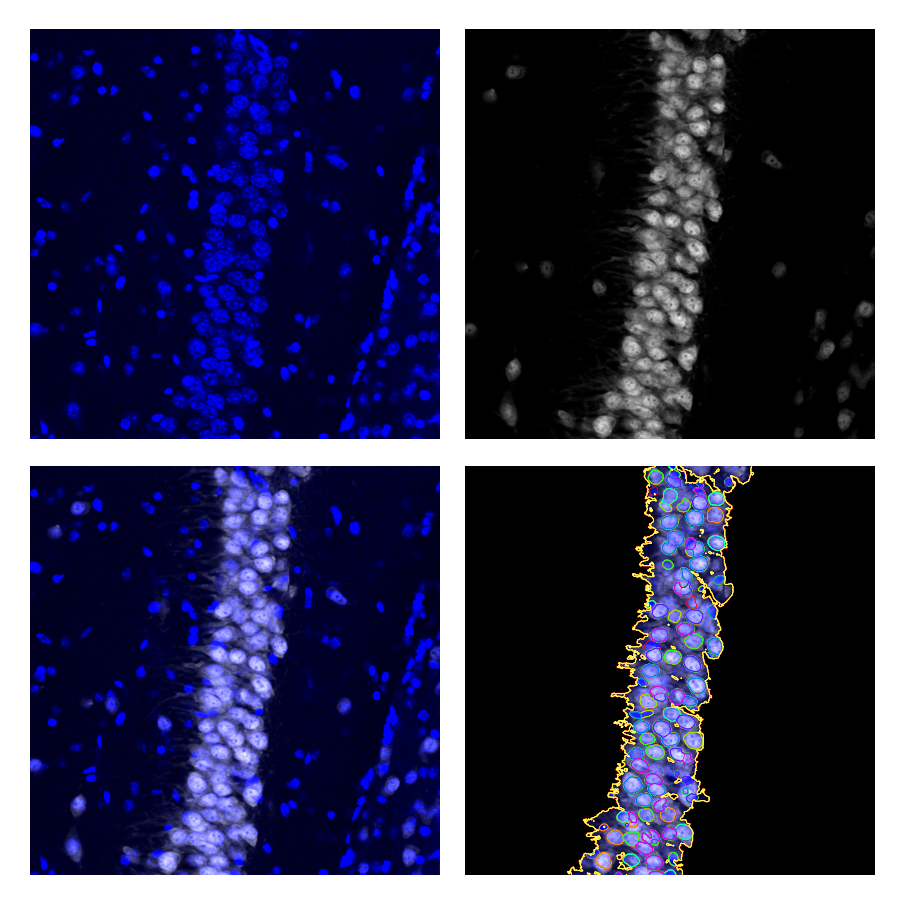

In [44]:
"""
Sample Image
"""
sample_z =18
volume_fig,ax=plt.subplots(2,2,figsize=(3,3))
ax=ax.flatten()
for a in ax:
    a.set_axis_off()

dapi_rgb = np_to_rgb(tiff_data_raw[sample_z,0,:,:],channel_bal=[0,0,1])*6

neun_rgb = np_to_rgb(tiff_data_raw[sample_z,1,:,:],channel_bal=[1,1,1])
merge = dapi_rgb+neun_rgb

ax[0].imshow(dapi_rgb)
ax[1].imshow(neun_rgb)
ax[2].imshow(merge)
ax[3].imshow(merge * np.stack([neun_layer_mask]*3,axis=-1))


nuc_edges = ski.filters.sobel(nuclear_masks[sample_z,:,:])>0.0002
# ax[3].contour(nuc_edges,linewidths=.2,cmap='hsv')
ax[3].contour(nuclear_masks[sample_z],linewidths=.2,cmap='hsv')
ax[3].contour(neun_layer_mask*5,linewidths=.2,cmap='hot')
plt.tight_layout()

volume_fig.savefig('volume_fig.svg')


In [45]:
"""
Validate Nuc ROI's
"""
def quant_entities(entity_mask):
    entity_mask_f = entity_mask.flatten()
    ent_ids = np.unique(entity_mask_f)
    bins = np.insert(ent_ids+0.5, 0, -0.5, axis=0)

quant_entities(nuclear_masks)